In [1]:
# Import 
import os
import time
import json
import random
import datetime
import numpy as np
import pandas as pd

from IPython.display import display

from pathlib import Path

from tyssue import config
from tyssue import Sheet

from tyssue.io import hdf5
from tyssue.io.hdf5 import load_datasets

from tyssue.core.history import History 

from tyssue.dynamics import SheetModel as basemodel
from tyssue.dynamics import units, effectors, model_factory

from tyssue.solvers.quasistatic import QSSolver
from tyssue.solvers.viscous import EulerSolver

from tyssue.draw import sheet_view
from tyssue.draw import highlight_faces, create_gif
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.draw.ipv_draw import sheet_view as ipv_draw 

from tyssue.behaviors.event_manager import EventManager
from tyssue.behaviors.sheet import actions, basic_events
#from tyssue.behaviors.sheet.apoptosis_events import apoptosis

import matplotlib.pyplot as plt
%matplotlib inline

try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')


In [2]:
from polarity.dynamics import model, RadialTension
from polarity.dynamics import EllipsoidLameGeometry as geom

from polarity.apoptosis import apoptosis, apoptosis_patterning

from polarity.toolbox import (init,
                              define_fold_position,
                              apoptosis_ventral,
                              apoptosis_lateral,
                              apoptosis_dorsal,
                             )

In [3]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/test_20190813_one_fold_viscousSolver')

sim_save_dir = SIM_DIR

try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

In [4]:
model = model_factory(
    [
        RadialTension,
        effectors.FaceContractility,
        effectors.FaceAreaElasticity,
        effectors.LumenVolumeElasticity,
    ], effectors.FaceAreaElasticity)

In [5]:
# Init superegg tissue 
sheet = init()

### We first use quasistatic gradient descent to do a first return to equilibrium

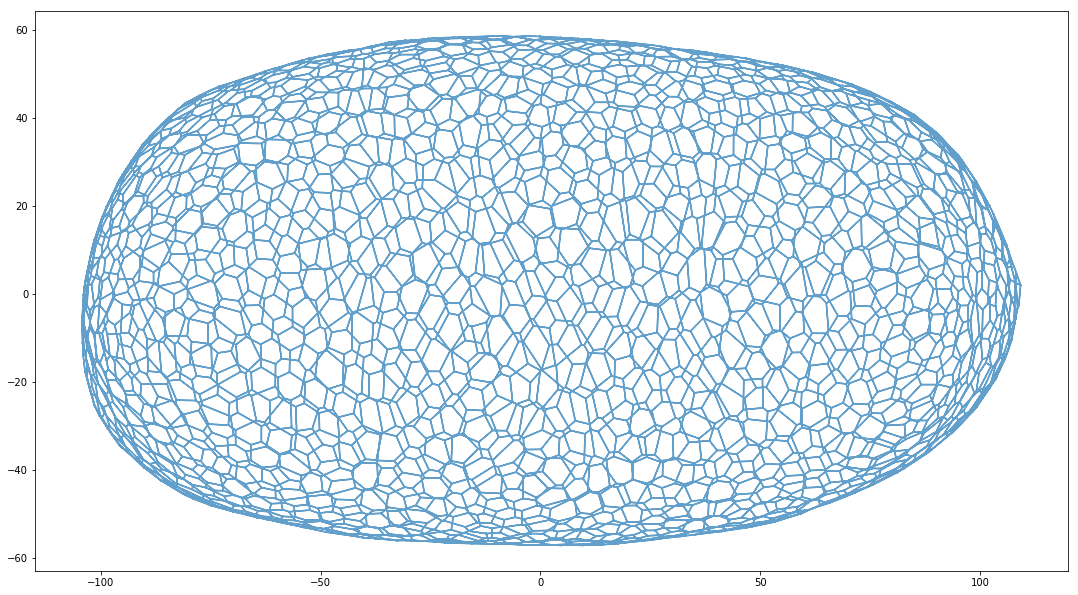

In [6]:
solver = QSSolver(with_t1=True, with_t3=False, with_collisions=False)
res = solver.find_energy_min(sheet, geom, model)
backupSheet = sheet.copy()

fig, ax = quick_edge_draw(sheet, ['z', 'x'],
                              alpha=0.7)
fig.set_size_inches(18.5, 10.5, forward=True)

In [7]:
sheet = backupSheet.copy()

In [8]:
"""import ipyvolume as ipv
ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':sheet.vert_df.y*(sheet.vert_df.y>0),
                         'colormap':'viridis'})
fig"""
import ipyvolume as ipv
ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'white'},
                      face={'color':'black', 'visible':True})
fig



Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0…

# Init basic information for fold formation

- position of the fold
- define 3 "categories" of apoptotic cells

In [9]:
define_fold_position(sheet, fold_number = 1, position=[-7, 7])
print(len(sheet.face_df[sheet.face_df.fold==1]))

ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'lightslategrey',
                         'visible':True},
                   face={'color': sheet.face_df.fold,
                        'colormap':'Reds',
                        'visible':True})
fig


112


Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0…

In [10]:
sheet.face_df['apoptosis'] = 0
apoptosis_ventral(sheet, 1)
apoptosis_lateral(sheet, 1)
apoptosis_dorsal(sheet, 1)

ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'lightslategrey',
                         'visible':True},
                   face={'color': sheet.face_df.apoptosis,
                        'colormap':'Reds',
                        'visible':True})
fig

print(len(sheet.face_df[sheet.face_df.fold>0]))
print(len(sheet.face_df[sheet.face_df.apoptosis>0]))
print(len(sheet.face_df[sheet.face_df.apoptosis==1]))
print(len(sheet.face_df[sheet.face_df.apoptosis==2]))
print(len(sheet.face_df[sheet.face_df.apoptosis==3]))


112
30
16
13
1


In [11]:
backupSheet2 = sheet.copy()

# Starting the viscous solver

In [12]:
# il faut faire les initialisations du manager et
# du solver plutôt dans run sim pour repartir sur de bonne base à chaque fois
"""
# Initiate manager
manager = EventManager('face')

solver = EulerSolver(
    sheet,
    geom, 
    model,
    manager = manager,
    bounds = (-sheet.edge_df.length.median()/10,
        sheet.edge_df.length.median()/10)
    )

manager.update()
sheet.vert_df['viscosity'] = 0.1"""

"\n# Initiate manager\nmanager = EventManager('face')\n\nsolver = EulerSolver(\n    sheet,\n    geom, \n    model,\n    manager = manager,\n    bounds = (-sheet.edge_df.length.median()/10,\n        sheet.edge_df.length.median()/10)\n    )\n\nmanager.update()\nsheet.vert_df['viscosity'] = 0.1"

In [13]:
default_pattern=    {
        "t":0,
        "dt":0.1
    }
def apoptosis_patterning(sheet, manager, **kwargs):
    """Apoptosis process patterning, which put cell in apoptosis progressively.


    """
    specs = default_pattern
    specs.update(**kwargs)
    # variable a passer en parametre?
    t = specs['t']
    
    phi_min = -t*max(np.abs(sheet.face_df.phi))/120+max(np.abs(sheet.face_df.phi))

    l_index_apoptosis_cell = sheet.face_df[(np.abs(sheet.face_df.phi)>phi_min) 
                                           & (sheet.face_df.apoptosis>0)
                                          ].index.values
    apopto_kwargs = sheet.settings['apoptosis'].copy()
    for c in l_index_apoptosis_cell:
        apopto_kwargs.update(
        {
            'face_id': c,
        }
        )
        manager.append(apoptosis, **apopto_kwargs)

    
    specs.update({"t" : specs['t']+specs['dt']})
    manager.append(apoptosis_patterning, **specs)


In [21]:
def save_sheet(history, path="", start_number = 0., dt = 0.1):
    times = history.time_stamps.shape[0]
    i = start_number
    for t in range(times):
        sheet = history.retrieve(i)
        hdf5.save_datasets(path+'/movie_{:.2f}.hf5'.format(i), sheet)
        i+=dt
        

def run_sim(sim_save_dir, sheet, constriction, radial_tension, iteration=0):
    
    dirname = '{}_constriction_{}_radialtension'.format(
        constriction, radial_tension)
    dirname = os.path.join(sim_save_dir, dirname)
    
    print('starting {}'.format(dirname))
    try:
        os.mkdir(dirname)
    except IOError:
        pass
    
    apoptosis_settings = {
        "critical_area": 0.5,
        "contract_rate": constriction,
        "basal_contract_rate": 1.01,
        "shrink_span": 2,
        "radial_tension": radial_tension,
        "max_traction":10,
        "current_traction":0,
        "geom": geom,
    }

    # Add some information to the sheet and copy initial sheet
    sheet2 = sheet.copy(deep_copy=True)
    sheet2.face_df['id'] = sheet2.face_df.index.values
    sheet2.settings['apoptosis'] = apoptosis_settings
    

    #sheet2 = apoptosis_process(dirname, solver, sheet2)
    
    # Initiate manager
    manager = EventManager('face')
    #manager.append(basic_events.reconnect)
    
    #Initiate history to save all columns in all df
    history = History(sheet2, extra_cols={"face": sheet2.face_df.columns,
                                          "edge": list(sheet2.edge_df.columns),
                                          "vert": list(sheet2.vert_df.columns)
                                         })
    
    # Starting viscous solver
    solver = EulerSolver(
    sheet2,
    geom, 
    model,
    history = history,
    manager = manager,
    bounds = (-sheet2.edge_df.length.median()/10,
        sheet2.edge_df.length.median()/10)
    )

    manager.update()
    sheet2.vert_df['viscosity'] = 0.1
    
    
    # Solving part... 
    dt = 0.1
    sheet2.settings["dt"] = dt
    
    manager.append(apoptosis_patterning)
    manager.update()
    
    
    # Fold process ~ 3H
    # Apoptotic process ~ 30min
    # -> apical constriction ~20min
    # -> force apico basal ~ 10min
    #solver.solve(30-dt, dt)
    solver.solve(15-dt, dt)
    save_sheet(solver.history, path=dirname, start_number=0, dt=dt)
    
    print(solver.history.time_stamps.shape)
    print('{} done'.format(dirname))
    print('~~~~~~~~~~~~~~~~~~~~~\n')
    
    #libère la mémoire ? 
    del solver
    
    return sheet2

In [23]:
from datetime import datetime
global_start=datetime.now()
print ("start : " + str(global_start))

for c in [1.08]:
    sheet= backupSheet2.copy()
    sheet_out=run_sim(sim_save_dir, sheet, c, 10e20, 0)
global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)


start : 2019-08-14 15:30:01.621466
starting /home/admin-suz/Documents/Simulations/test_20190813_one_fold_viscousSolver/1.08_constriction_1e+201_radialtension
(150,)
/home/admin-suz/Documents/Simulations/test_20190813_one_fold_viscousSolver/1.08_constriction_1e+201_radialtension done
~~~~~~~~~~~~~~~~~~~~~

end : 2019-08-14 15:33:45.796686
Duree totale d execution : 
		
0:03:44.175220


In [16]:
sheet_ = solver_out.history.retrieve(119*0.1)
sheet_.face_df.area.unique()

NameError: name 'solver_out' is not defined

In [ ]:
t=600
phi_min = -t*max(np.abs(sheet.face_df.phi))/120+max(np.abs(sheet.face_df.phi))
l_enter = sheet.face_df[(np.abs(sheet.face_df.phi)>phi_min) & (sheet.face_df.apoptosis>0)].index.values
print(l_enter)

dt = 0.1

for j in l_enter:
    sept_area=[]
    t=0
    for i in range (solver_out.history.time_stamps.shape[0]):
        sheet_ = solver_out.history.retrieve(np.round(t,1))
        sept_area.append(sheet_.face_df.loc[j, 'area'])
        t+=dt
    plt.plot(sept_area, label = j)
    
plt.legend()

In [ ]:
j=1118
sept_area=[]
t=0
for i in range (solver_out.history.time_stamps.shape[0]):
    sheet_ = solver_out.history.retrieve(np.round(t,1))
    sept_area.append(sheet_.face_df.loc[j, 'area'])
    t+=dt
plt.plot(sept_area, label = j)

In [ ]:
sheet_ = solver_out.history.retrieve(0)
dt = 0.1
t=0
tension=[]
for i in range (solver_out.history.time_stamps.shape[0]):
    sheet_ = solver_out.history.retrieve(t)
    tension.append(sheet_.vert_df.radial_tension.unique().max())
    t+=dt

In [ ]:
plt.plot(tension)

In [ ]:
dico_id_t={}
for t in range (600):
    phi_min = -t*max(np.abs(sheet.face_df.phi))/120+max(np.abs(sheet.face_df.phi))
    l_enter = sheet.face_df[(np.abs(sheet.face_df.phi)>phi_min) & (sheet.face_df.apoptosis>0)].index.values
    for id in l_enter:
        if id not in dico_id_t:
            dico_id_t[id]=t

    

In [ ]:
list_dir = os.listdir(sim_save_dir)

dsets = hdf5.load_datasets(os.path.join(os.path.join(sim_save_dir,list_dir[0]), 'movie_0.00.hf5'),
                               data_names=['vert', 'edge', 'face'])
        
sheet = Sheet('ellipse', dsets)
t=600
phi_min = -t*max(np.abs(sheet.face_df.phi))/120+max(np.abs(sheet.face_df.phi))
l_enter = sheet.face_df[(np.abs(sheet.face_df.phi)>phi_min) & (sheet.face_df.apoptosis>0)].index.values
dt = 0.1
color=['red','blue', 'green','yellow']
i=0
constriction_8={}
for dir in list_dir[0:1]:
    print(dir)
    for j in l_enter:
        sept_area=[]
        hfs = os.listdir(os.path.join(sim_save_dir,dir))
        hfs.sort()
        for hdf_file in hfs :
            
            dsets = hdf5.load_datasets(os.path.join(os.path.join(sim_save_dir,dir), hdf_file),
                               data_names=['vert', 'edge', 'face'])
        
            sheet = Sheet('ellipse', dsets)
    
            sept_area.append(sheet.face_df.loc[j, 'area'])
        constriction_8[j]=sept_area
        
        plt.plot(sept_area, color=color[i])
    i=i+1
    

In [ ]:
i = 0
for key, values in constriction_8.items():
    if i == 10:
        break
    plt.plot(values[dico_id_t[key]:])
    i+=1